In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr

In [17]:
# Read the list of deciduous sites and their NDRE time series
#landscape
#dsites_data = pd.read_csv("/data1/jbk/projects/climate/tropics/marcos_longo/drought_deciduous_sites_MarcosLongo.ndre", delimiter=" ")
#asha
dsites_data = pd.read_csv("/home/jbk/projects/climate/tropics/marcos_longo/drought_deciduous_sites_MarcosLongo.ndre", delimiter="|")

# extract NDRE timesereis for BCI - 25 x 6 = 150 values
bci_ndre = dsites_data[dsites_data.code == "BCI"].loc[:, dsites_data.columns.str.contains('n20')]
pnm_ndre = dsites_data[dsites_data.code == "PNM"].loc[:, dsites_data.columns.str.contains('n20')]
#bci_ndre.iloc[0,:].values

In [18]:
# read ERA5 data for Costa Rica + Panama for 2017-2022
era5 = xr.open_mfdataset('/home/jbk/projects/climate/tropics/costa_rica_panama/era5/15d_20*_daily_costarica_panama_EPSG4326_allvars.nc')
# list of era5 variables
evars=["t2m", "ssrd", "sshf", "slhf", "tp", "ro", "swvl1", "swvl2", "swvl3", "swvl4", "e", "evavt", "pev", "d2m", "vpd", "ndre"]
bci_era5_subset = era5.sel(latitude=9.154, longitude=-79.848, method='nearest')
bci_era5_subset['ndre'] = bci_ndre.iloc[0,:].values

In [19]:
## We have run xgboost for the site in /home/jbk/projects/climate/tropics/marcos_longo and will analyze the shap values/order here 
bci_shap_values = pd.read_csv("/home/jbk/projects/climate/tropics/marcos_longo/shap_values_bci.csv", usecols=np.arange(0,150*35), header=None, delimiter=",")
bci_shap_values = bci_shap_values.to_numpy().reshape(150,35)
mean_bci_shap_values = np.absolute(bci_shap_values).mean(axis=0)

bci_shap_order = pd.read_csv("/home/jbk/projects/climate/tropics/marcos_longo/shap_order_bci.csv", header=None, usecols=np.arange(0,35), delimiter=",")
nondre_order = nondre_dominant(bci_shap_order)

In [20]:
# create list of dates
dates = pd.date_range('2017-01-01', periods=25, freq='15D')
dates = dates.union(pd.date_range('2018-01-01', periods=25, freq='15D'))
dates = dates.union(pd.date_range('2019-01-01', periods=25, freq='15D'))
dates = dates.union(pd.date_range('2020-01-01', periods=25, freq='15D'))
dates = dates.union(pd.date_range('2021-01-01', periods=25, freq='15D'))
dates = dates.union(pd.date_range('2022-01-01', periods=25, freq='15D'))

#fig, ax = plt.subplots(1,1, figsize=(15,5))
#ax.plot(dates, bci_ndre.to_numpy()[0])
#ax.set_ylim([0,1])
#ax.set_xlim([datetime.date(2017, 1, 1), datetime.date(2018, 12, 31)])

#plt.show()

In [21]:
cats = ["ndre_1", "ndre_2", "ndre_3", "t2m", "t2m_1", "t2m_2", "t2m_3", "tp", "tp_1", "tp_2", "tp_3", "swvl1", "swvl1_1", "swvl1_2", "swvl1_3", "swvl2", "swvl2_1", "swvl2_2", "swvl2_3", "swvl3", "swvl3_1", "swvl3_2", "swvl3_3", "swvl4", "swvl4_1", "swvl4_2", "swvl4_3", "vpd" , "vpd_1", "vpd_2", "vpd_3", "ssrd", "ssrd_1", "ssrd_2", "ssrd_3"]
bci_shap_values[[1,2],:].shape

(2, 35)

In [22]:
def nondre_dominant(data):
    ndre=[0,1,2]
    #print(data.shape)
    for l in range(data.shape[0]):
        res=[i for i in data.loc[l] if i not in ndre]
    return res
    
# we calculate the overall shap order by taking mean of shap values over the whole time series
dominant = np.flip(np.absolute(bci_shap_values).mean(axis=0).argsort())
# and we remove the ndre vars to get nondre dominant variables
dominant_nondre = nondre_dominant(pd.DataFrame(dominant).T)
print(dominant_nondre)

# Dry season 
# Costa Rica and Panama have dry season Dec-April -- weeks 0 to 8 and weeks 23, 25
dry_weeks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24,                                                        # 2017
          1*25+0, 1*25+1, 1*25+2, 1*25+3, 1*25+4, 1*25+5, 1*25+6, 1*25+7, 1*25+8, 1*25+23, 1*25+24,  # 2018
          2*25+0, 2*25+1, 2*25+2, 2*25+3, 2*25+4, 2*25+5, 2*25+6, 2*25+7, 2*25+8, 2*25+23, 2*25+24,  # 2019
          3*25+0, 3*25+1, 3*25+2, 3*25+3, 3*25+4, 3*25+5, 3*25+6, 3*25+7, 3*25+8, 3*25+23, 3*25+24,  # 2020
          4*25+0, 4*25+1, 4*25+2, 4*25+3, 4*25+4, 4*25+5, 4*25+6, 4*25+7, 4*25+8, 4*25+23, 4*25+24,  # 2021
          5*25+0, 5*25+1, 5*25+2, 5*25+3, 5*25+4, 5*25+5, 5*25+6, 5*25+7, 5*25+8, 5*25+23, 5*25+24,  # 2022
          ]
dominant = np.flip(np.absolute(bci_shap_values[dry_weeks,:]).mean(axis=0).argsort())
dominant_nondre = nondre_dominant(pd.DataFrame(dominant).T)
print(dominant_nondre)

# Wet season 
# Costa Rica and Panama have wet season May-November -- weeks 9 to 22
wet_weeks=[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,                                                                      # 2017
          1*25+9, 1*25+10, 1*25+11, 1*25+12, 1*25+13, 1*25+14, 1*25+15, 1*25+16, 1*25+17, 1*25+18, 1*25+19,  1*25+20, 1*25+21, 1*25+22, # 2018
          2*25+9, 2*25+10, 2*25+11, 2*25+12, 2*25+13, 2*25+14, 2*25+15, 2*25+16, 2*25+17, 2*25+18, 2*25+19,  2*25+20, 2*25+21, 2*25+22, # 2018
          3*25+9, 3*25+10, 3*25+11, 3*25+12, 3*25+13, 3*25+14, 3*25+15, 3*25+16, 3*25+17, 3*25+18, 3*25+19,  3*25+20, 3*25+21, 3*25+22, # 2018
          4*25+9, 4*25+10, 4*25+11, 4*25+12, 4*25+13, 4*25+14, 4*25+15, 4*25+16, 4*25+17, 4*25+18, 4*25+19,  4*25+20, 4*25+21, 4*25+22, # 2018
          5*25+9, 5*25+10, 5*25+11, 5*25+12, 5*25+13, 5*25+14, 5*25+15, 5*25+16, 5*25+17, 5*25+18, 5*25+19,  5*25+20, 5*25+21, 5*25+22, # 2018
          ]
dominant = np.flip(np.absolute(bci_shap_values[dry_weeks,:]).mean(axis=0).argsort())
dominant_nondre = nondre_dominant(pd.DataFrame(dominant).T)
print(dominant_nondre)
print(np.take(cats, dominant_nondre))

[26, 32, 22, 12, 5, 33, 14, 27, 10, 6, 29, 30, 4, 16, 3, 34, 13, 8, 28, 11, 7, 31, 21, 24, 9, 17, 20, 15, 23, 19, 18, 25]
[32, 26, 22, 12, 14, 5, 33, 27, 29, 30, 6, 34, 3, 13, 16, 4, 10, 11, 7, 8, 28, 31, 21, 24, 9, 17, 20, 19, 15, 23, 18, 25]
[32, 26, 22, 12, 14, 5, 33, 27, 29, 30, 6, 34, 3, 13, 16, 4, 10, 11, 7, 8, 28, 31, 21, 24, 9, 17, 20, 19, 15, 23, 18, 25]
['ssrd_1' 'swvl4_3' 'swvl3_3' 'swvl1_1' 'swvl1_3' 't2m_2' 'ssrd_2' 'vpd'
 'vpd_2' 'vpd_3' 't2m_3' 'ssrd_3' 't2m' 'swvl1_2' 'swvl2_1' 't2m_1' 'tp_3'
 'swvl1' 'tp' 'tp_1' 'vpd_1' 'ssrd' 'swvl3_2' 'swvl4_1' 'tp_2' 'swvl2_2'
 'swvl3_1' 'swvl3' 'swvl2' 'swvl4' 'swvl2_3' 'swvl4_2']


In [23]:
##### Collapse time to dry and wet seasons 
##### Collapse variables to just six variables --- this merges all time lags together + merges vol water cont at all depths

def nondre_dominant_simplified(data):
    ndre=[0]
    #print(data.shape)
    for l in range(data.shape[0]):
        res=[i for i in data.loc[l] if i not in ndre]
    return res

# Let's collapse our variables to only 6 
# ndre 0-2 t2m 3-6 tp 7-10 swvl 11-26 vpd 27-30 ssrd 31-34
cats_simplified = ["ndre", "t2m", "tp", "swvl", "vpd", "ssrd"]
bci_shap_values_simplified = np.zeros((150, 6))

for t in range(150):
    bci_shap_values_simplified[t,0] = bci_shap_values[t,0:2+1].sum()
    bci_shap_values_simplified[t,1] = bci_shap_values[t,3:6+1].sum()
    bci_shap_values_simplified[t,2] = bci_shap_values[t,7:10+1].sum()
    bci_shap_values_simplified[t,3] = bci_shap_values[t,11:26+1].sum()
    bci_shap_values_simplified[t,4] = bci_shap_values[t,27:30+1].sum()
    bci_shap_values_simplified[t,5] = bci_shap_values[t,31:34+1].sum()
#bci_shap_values_simplified

order=np.zeros((15), dtype=np.int64)
simple_shap = np.zeros((15))


# we calculate the overall shap order by taking mean of shap values over the whole time series
dominant = np.flip(np.absolute(bci_shap_values_simplified).mean(axis=0).argsort())
# and we remove the ndre vars to get nondre dominant variables
dominant_nondre = nondre_dominant_simplified(pd.DataFrame(dominant).T)
order[0:5] = dominant_nondre
simple_shap[0:5] = np.absolute(bci_shap_values_simplified).mean(axis=0)[1:]
print(dominant_nondre)


# Dry season 
# Costa Rica and Panama have dry season Dec-April -- weeks 0 to 8 and weeks 23, 25
dry_weeks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24,                                                        # 2017
          1*25+0, 1*25+1, 1*25+2, 1*25+3, 1*25+4, 1*25+5, 1*25+6, 1*25+7, 1*25+8, 1*25+23, 1*25+24,  # 2018
          2*25+0, 2*25+1, 2*25+2, 2*25+3, 2*25+4, 2*25+5, 2*25+6, 2*25+7, 2*25+8, 2*25+23, 2*25+24,  # 2019
          3*25+0, 3*25+1, 3*25+2, 3*25+3, 3*25+4, 3*25+5, 3*25+6, 3*25+7, 3*25+8, 3*25+23, 3*25+24,  # 2020
          4*25+0, 4*25+1, 4*25+2, 4*25+3, 4*25+4, 4*25+5, 4*25+6, 4*25+7, 4*25+8, 4*25+23, 4*25+24,  # 2021
          5*25+0, 5*25+1, 5*25+2, 5*25+3, 5*25+4, 5*25+5, 5*25+6, 5*25+7, 5*25+8, 5*25+23, 5*25+24,  # 2022
          ]
dominant = np.flip(np.absolute(bci_shap_values_simplified[dry_weeks,:]).mean(axis=0).argsort())
dominant_nondre = nondre_dominant_simplified(pd.DataFrame(dominant).T)
order[5:10] = dominant_nondre
simple_shap[5:10] = np.absolute(bci_shap_values_simplified[dry_weeks,:]).mean(axis=0)[1:]
print(dominant_nondre)

# Wet season 
# Costa Rica and Panama have wet season May-November -- weeks 9 to 22
wet_weeks=[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,                                                                       # 2017
          1*25+9, 1*25+10, 1*25+11, 1*25+12, 1*25+13, 1*25+14, 1*25+15, 1*25+16, 1*25+17, 1*25+18, 1*25+19,  1*25+20, 1*25+21, 1*25+22, # 2018
          2*25+9, 2*25+10, 2*25+11, 2*25+12, 2*25+13, 2*25+14, 2*25+15, 2*25+16, 2*25+17, 2*25+18, 2*25+19,  2*25+20, 2*25+21, 2*25+22, # 2019
          3*25+9, 3*25+10, 3*25+11, 3*25+12, 3*25+13, 3*25+14, 3*25+15, 3*25+16, 3*25+17, 3*25+18, 3*25+19,  3*25+20, 3*25+21, 3*25+22, # 2020
          4*25+9, 4*25+10, 4*25+11, 4*25+12, 4*25+13, 4*25+14, 4*25+15, 4*25+16, 4*25+17, 4*25+18, 4*25+19,  4*25+20, 4*25+21, 4*25+22, # 2021
          5*25+9, 5*25+10, 5*25+11, 5*25+12, 5*25+13, 5*25+14, 5*25+15, 5*25+16, 5*25+17, 5*25+18, 5*25+19,  5*25+20, 5*25+21, 5*25+22, # 2022
          ]
dominant = np.flip(np.absolute(bci_shap_values_simplified[wet_weeks,:]).mean(axis=0).argsort())
dominant_nondre = nondre_dominant_simplified(pd.DataFrame(dominant).T)
order[10:15] = dominant_nondre
simple_shap[10:15] = np.absolute(bci_shap_values_simplified[wet_weeks,:]).mean(axis=0)[1:]
print(dominant_nondre)
print(np.take(cats_simplified, dominant_nondre))
type(dominant_nondre)
print(order)
print(simple_shap)
type(order)

[3, 5, 1, 4, 2]
[3, 5, 1, 4, 2]
[3, 5, 1, 2, 4]
['swvl' 'ssrd' 't2m' 'tp' 'vpd']
[3 5 1 4 2 3 5 1 4 2 3 5 1 2 4]
[0.00190025 0.00083604 0.00529116 0.00124645 0.00293851 0.00261814
 0.0006625  0.00669985 0.00171476 0.00408108 0.0013362  0.00097239
 0.00418433 0.0008785  0.00204078]


numpy.ndarray

### Analyze phenocam data

In [27]:
# Read S2 NDRE time series at phenocam sites
 
phenocamsites_ndre = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/costa_rica_panama_phenocam_sites.ndre", delimiter="|")

# extract NDRE timesereis for BCI - 25 x 6 = 150 values
barrocolorado_ndre = phenocamsites_ndre[phenocamsites_ndre.phenocam == "barrocolorado"].loc[:, phenocamsites_ndre.columns.str.contains('n20')]
laselva_ndre = phenocamsites_ndre[phenocamsites_ndre.phenocam == "laselva"].loc[:, phenocamsites_ndre.columns.str.contains('n20')]
soltis_ndre = phenocamsites_ndre[phenocamsites_ndre.phenocam == "soltis"].loc[:, phenocamsites_ndre.columns.str.contains('n20')]


In [24]:
##########
## barrocolorado
### Read PHENOCAM data for BCI -- NDVI datasets from phenocam are incomplete so we will be using GCC instead
### read NDVI from phenocams
barrocolorado_MX_4000_phenocam_ndvi = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/barrocolorado/barrocolorado_MX_4000_ndvi_1day.txt", comment="#")

# read GCC
barrocolorado2_EB_1000_phenocam_gcc = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/barrocolorado/barrocolorado2_EB_1000_provisional_data/provisional_data/data_record_4/barrocolorado2_EB_1000_1day.csv", comment="#")
barrocolorado3_EB_1000_phenocam_gcc = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/barrocolorado/barrocolorado3_EB_1000_provisional_data/provisional_data/data_record_4/barrocolorado3_EB_1000_1day.csv", comment="#")
barrocolorado4_EB_1000_phenocam_gcc = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/barrocolorado/barrocolorado4_EB_1000_provisional_data/provisional_data/data_record_4/barrocolorado4_EB_1000_1day.csv", comment="#")
barrocolorado4_EB_2000_phenocam_gcc = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/barrocolorado/barrocolorado4_EB_2000_provisional_data/provisional_data/data_record_4/barrocolorado4_EB_2000_1day.csv", comment="#")

# read MODIS
barrocolorado2_EB_1000_phenocam_modis = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/barrocolorado/barrocolorado2_EB_1000_provisional_data/provisional_data/modis_time_series/barrocolorado2_gee_subset.csv", comment="#")
barrocolorado3_EB_1000_phenocam_modis = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/barrocolorado/barrocolorado3_EB_1000_provisional_data/provisional_data/modis_time_series/barrocolorado3_gee_subset.csv", comment="#")
barrocolorado4_EB_1000_phenocam_modis = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/barrocolorado/barrocolorado4_EB_1000_provisional_data/provisional_data/modis_time_series/barrocolorado4_gee_subset.csv", comment="#")
barrocolorado4_EB_2000_phenocam_modis = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/barrocolorado/barrocolorado4_EB_2000_provisional_data/provisional_data/modis_time_series/barrocolorado4_gee_subset.csv", comment="#")

# Calculate MODIS NDVI using Band 1 (Red) and Band 2 (NIR)
barrocolorado2_EB_1000_phenocam_modis['ndvi'] = (barrocolorado2_EB_1000_phenocam_modis.Nadir_Reflectance_Band2 - barrocolorado2_EB_1000_phenocam_modis.Nadir_Reflectance_Band1) / (barrocolorado2_EB_1000_phenocam_modis.Nadir_Reflectance_Band2 + barrocolorado2_EB_1000_phenocam_modis.Nadir_Reflectance_Band1)
barrocolorado3_EB_1000_phenocam_modis['ndvi'] = (barrocolorado3_EB_1000_phenocam_modis.Nadir_Reflectance_Band2 - barrocolorado3_EB_1000_phenocam_modis.Nadir_Reflectance_Band1) / (barrocolorado3_EB_1000_phenocam_modis.Nadir_Reflectance_Band2 + barrocolorado3_EB_1000_phenocam_modis.Nadir_Reflectance_Band1)
barrocolorado4_EB_1000_phenocam_modis['ndvi'] = (barrocolorado4_EB_1000_phenocam_modis.Nadir_Reflectance_Band2 - barrocolorado4_EB_1000_phenocam_modis.Nadir_Reflectance_Band1) / (barrocolorado4_EB_1000_phenocam_modis.Nadir_Reflectance_Band2 + barrocolorado4_EB_1000_phenocam_modis.Nadir_Reflectance_Band1)
barrocolorado4_EB_2000_phenocam_modis['ndvi'] = (barrocolorado4_EB_2000_phenocam_modis.Nadir_Reflectance_Band2 - barrocolorado4_EB_2000_phenocam_modis.Nadir_Reflectance_Band1) / (barrocolorado4_EB_2000_phenocam_modis.Nadir_Reflectance_Band2 + barrocolorado4_EB_2000_phenocam_modis.Nadir_Reflectance_Band1)

# Change date column to a panda datetime object
barrocolorado_MX_4000_phenocam_ndvi['date'] = pd.to_datetime(barrocolorado_MX_4000_phenocam_ndvi['date'], format="%Y-%m-%d")

barrocolorado2_EB_1000_phenocam_gcc['date'] = pd.to_datetime(barrocolorado2_EB_1000_phenocam_gcc['date'], format="%Y-%m-%d")
barrocolorado3_EB_1000_phenocam_gcc['date'] = pd.to_datetime(barrocolorado3_EB_1000_phenocam_gcc['date'], format="%Y-%m-%d")
barrocolorado4_EB_1000_phenocam_gcc['date'] = pd.to_datetime(barrocolorado4_EB_1000_phenocam_gcc['date'], format="%Y-%m-%d")
barrocolorado4_EB_2000_phenocam_gcc['date'] = pd.to_datetime(barrocolorado4_EB_2000_phenocam_gcc['date'], format="%Y-%m-%d")

barrocolorado2_EB_1000_phenocam_modis['date'] = pd.to_datetime(barrocolorado2_EB_1000_phenocam_modis['date'], format="%Y-%m-%d")
barrocolorado3_EB_1000_phenocam_modis['date'] = pd.to_datetime(barrocolorado3_EB_1000_phenocam_modis['date'], format="%Y-%m-%d")
barrocolorado4_EB_1000_phenocam_modis['date'] = pd.to_datetime(barrocolorado4_EB_1000_phenocam_modis['date'], format="%Y-%m-%d")
barrocolorado4_EB_2000_phenocam_modis['date'] = pd.to_datetime(barrocolorado4_EB_2000_phenocam_modis['date'], format="%Y-%m-%d")

##########

##########
## laselva
### Read PHENOCAM data for La Selva -- NDVI datasets from phenocam are incomplete so we will be using GCC instead
### read NDVI from phenocams
laselva_EB_1000_phenocam_ndvi = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/laselva/laselva_EB_1000_ndvi_1day.txt", comment="#")
laselva2_EB_1000_phenocam_ndvi = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/laselva/laselva2_EB_1000_ndvi_1day.txt", comment="#")
laselva2_EB_1001_phenocam_ndvi = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/laselva/laselva2_EB_1001_ndvi_1day.txt", comment="#")

# read GCC
laselva_EB_1000_phenocam_gcc = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/laselva/laselva_EB_1000_provisional_data/provisional_data/data_record_4/laselva_EB_1000_1day.csv", comment="#")
laselva2_EB_1000_phenocam_gcc = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/laselva/laselva2_EB_1000_provisional_data/provisional_data/data_record_4/laselva2_EB_1000_1day.csv", comment="#")
#laselva2_EB_1001_phenocam_gcc = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/laselva/laselva2_EB_1001_provisional_data/provisional_data/data_record_4/laselva2_EB_1001_1day.csv", comment="#")

# read MODIS
laselva_EB_1000_phenocam_modis = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/laselva/laselva_EB_1000_provisional_data/provisional_data/modis_time_series/laselva_gee_subset.csv", comment="#")
laselva2_EB_1000_phenocam_modis = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/laselva/laselva2_EB_1000_provisional_data/provisional_data/modis_time_series/laselva2_gee_subset.csv", comment="#")
#laselva2_EB_1001_phenocam_modis = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/laselva/laselva2_EB_1001_provisional_data/provisional_data/modis_time_series/laselva_gee_subset.csv", comment="#")

# Calculate MODIS NDVI using Band 1 (Red) and Band 2 (NIR)
laselva_EB_1000_phenocam_modis['ndvi'] = (laselva_EB_1000_phenocam_modis.Nadir_Reflectance_Band2 - laselva_EB_1000_phenocam_modis.Nadir_Reflectance_Band1) / (laselva_EB_1000_phenocam_modis.Nadir_Reflectance_Band2 + laselva_EB_1000_phenocam_modis.Nadir_Reflectance_Band1)
laselva2_EB_1000_phenocam_modis['ndvi'] = (laselva2_EB_1000_phenocam_modis.Nadir_Reflectance_Band2 - laselva2_EB_1000_phenocam_modis.Nadir_Reflectance_Band1) / (laselva2_EB_1000_phenocam_modis.Nadir_Reflectance_Band2 + laselva2_EB_1000_phenocam_modis.Nadir_Reflectance_Band1)
#laselva2_EB_1001_phenocam_modis['ndvi'] = (laselva2_EB_1001_phenocam_modis.Nadir_Reflectance_Band2 - laselva2_EB_1001_phenocam_modis.Nadir_Reflectance_Band1) / (laselva2_EB_1001_phenocam_modis.Nadir_Reflectance_Band2 + laselva2_EB_1001_phenocam_modis.Nadir_Reflectance_Band1)

# Change date column to a panda datetime object
laselva_EB_1000_phenocam_ndvi['date'] = pd.to_datetime(laselva_EB_1000_phenocam_ndvi['date'], format="%Y-%m-%d")

laselva_EB_1000_phenocam_gcc['date'] = pd.to_datetime(laselva_EB_1000_phenocam_gcc['date'], format="%Y-%m-%d")
laselva2_EB_1000_phenocam_gcc['date'] = pd.to_datetime(laselva2_EB_1000_phenocam_gcc['date'], format="%Y-%m-%d")
#laselva2_EB_1001_phenocam_gcc['date'] = pd.to_datetime(laselva2_EB_1001_phenocam_gcc['date'], format="%Y-%m-%d")

laselva_EB_1000_phenocam_modis['date'] = pd.to_datetime(laselva_EB_1000_phenocam_modis['date'], format="%Y-%m-%d")
laselva2_EB_1000_phenocam_modis['date'] = pd.to_datetime(laselva2_EB_1000_phenocam_modis['date'], format="%Y-%m-%d")
#laselva2_EB_1001_phenocam_modis['date'] = pd.to_datetime(laselva2_EB_1001_phenocam_modis['date'], format="%Y-%m-%d")


##########

##########
## soltis
### Read PHENOCAM data for La Selva -- NDVI datasets from phenocam are incomplete so we will be using GCC instead
### read NDVI from phenocams
## no NDVI available for soltis

# read GCC
soltis_EB_1000_phenocam_gcc = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/soltis/soltis_EB_1000_provisional_data/provisional_data/data_record_4/soltis_EB_1000_1day.csv", comment="#")

# read MODIS
soltis_EB_1000_phenocam_modis = pd.read_csv("/home/jbk/projects/climate/tropics/data/phenocams/soltis/soltis_EB_1000_provisional_data/provisional_data/modis_time_series/soltis_gee_subset.csv", comment="#")

# Calculate MODIS NDVI using Band 1 (Red) and Band 2 (NIR)
soltis_EB_1000_phenocam_modis['ndvi'] = (soltis_EB_1000_phenocam_modis.Nadir_Reflectance_Band2 - soltis_EB_1000_phenocam_modis.Nadir_Reflectance_Band1) / (soltis_EB_1000_phenocam_modis.Nadir_Reflectance_Band2 + soltis_EB_1000_phenocam_modis.Nadir_Reflectance_Band1)

# Change date column to a panda datetime object
soltis_EB_1000_phenocam_gcc['date'] = pd.to_datetime(soltis_EB_1000_phenocam_gcc['date'], format="%Y-%m-%d")
soltis_EB_1000_phenocam_modis['date'] = pd.to_datetime(soltis_EB_1000_phenocam_modis['date'], format="%Y-%m-%d")

##########


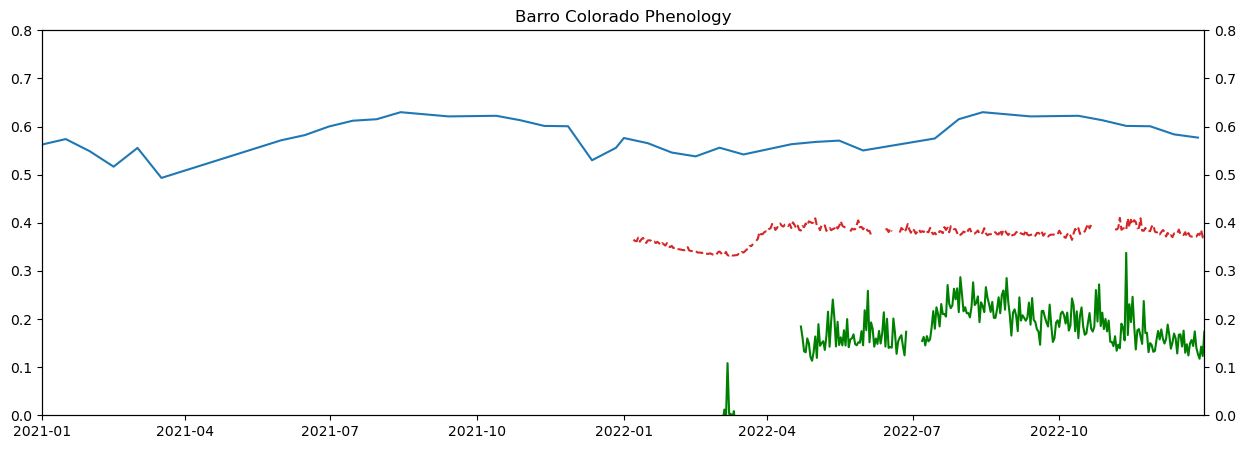

In [66]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax2 = ax.twinx() 

# S2 NDVI
ax.plot(dates, barrocolorado_ndre.to_numpy()[0])  ## UPDATE THIS
# Phenocam NDVI
ax.plot(barrocolorado_MX_4000_phenocam_ndvi['date'], barrocolorado_MX_4000_phenocam_ndvi['ndvi_90'], color='green')

#ax.plot(barrocolorado2_EB_1000_phenocam_modis['date'], barrocolorado2_EB_1000_phenocam_modis['ndvi'], color='green')
#ax.plot(barrocolorado3_EB_1000_phenocam_modis['date'], barrocolorado3_EB_1000_phenocam_modis['ndvi'], color='green')
#ax.plot(barrocolorado4_EB_1000_phenocam_modis['date'], barrocolorado4_EB_1000_phenocam_modis['ndvi'], color='green')
#ax.plot(barrocolorado4_EB_2000_phenocam_modis['date'], barrocolorado4_EB_2000_phenocam_modis['ndvi'], color='green')

# Phenocam GCC
ax2.plot(barrocolorado2_EB_1000_phenocam_gcc['date'], barrocolorado2_EB_1000_phenocam_gcc['gcc_90'], ls='--')
ax2.plot(barrocolorado3_EB_1000_phenocam_gcc['date'], barrocolorado3_EB_1000_phenocam_gcc['gcc_90'], ls='--')
ax2.plot(barrocolorado4_EB_1000_phenocam_gcc['date'], barrocolorado4_EB_1000_phenocam_gcc['gcc_90'], ls='--')
ax2.plot(barrocolorado4_EB_2000_phenocam_gcc['date'], barrocolorado4_EB_2000_phenocam_gcc['gcc_90'], ls='--')

ax2.set_ylim([0,0.8])
ax.set_ylim([0,0.8])
ax.set_xlim([datetime.date(2021, 1, 1), datetime.date(2022, 12, 31)])
ax.set_title("Barro Colorado Phenology")

plt.show()

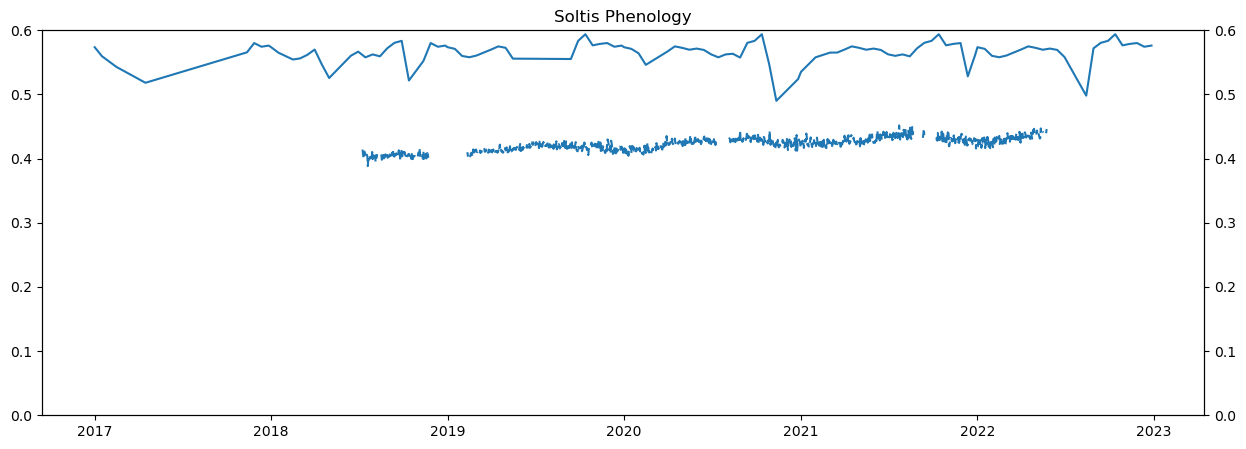

In [82]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax2 = ax.twinx() 

# S2 NDVI
ax.plot(dates, soltis_ndre.to_numpy()[0]) 
# Phenocam NDVI
#ax.plot(soltis_EB_1000_phenocam_ndvi['date'], soltis_EB_1000_phenocam_ndvi['ndvi_90'], color='green')
#ax.plot(soltis_EB_1000_phenocam_modis['date'], soltis_EB_1000_phenocam_modis['ndvi'], color='green')

# Phenocam GCC
ax2.plot(soltis_EB_1000_phenocam_gcc['date'], soltis_EB_1000_phenocam_gcc['gcc_90'], ls='--')

ax.set_ylim([0.0,0.6])
ax2.set_ylim([0.0,0.6])
#ax.set_xlim([datetime.date(2022, 1, 1), datetime.date(2023, 12, 31)])
ax.set_title("Soltis Phenology")
plt.show()

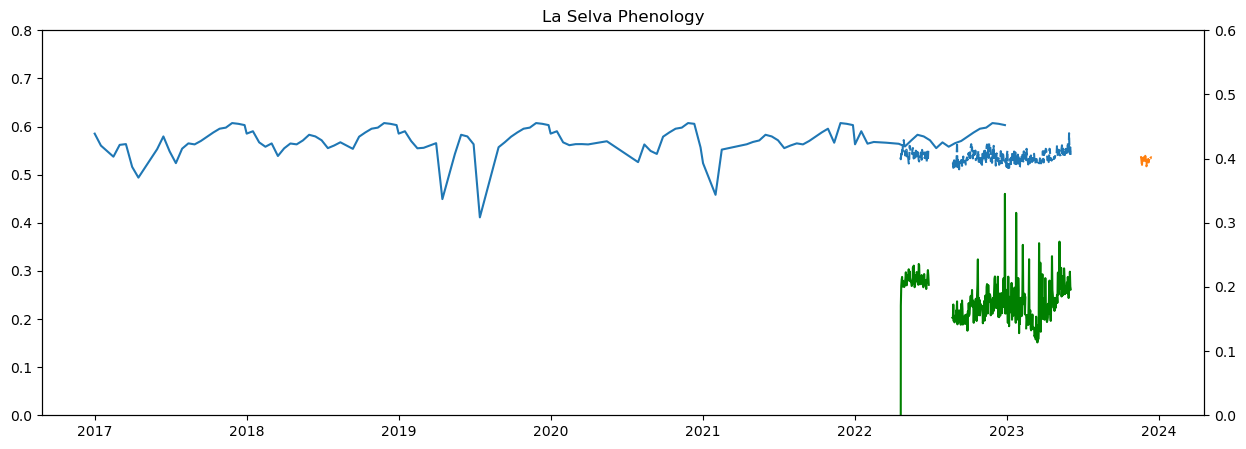

In [79]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax2 = ax.twinx() 

# S2 NDVI
ax.plot(dates, laselva_ndre.to_numpy()[0])
# Phenocam NDVI
ax.plot(laselva_EB_1000_phenocam_ndvi['date'], laselva_EB_1000_phenocam_ndvi['ndvi_90'], color='green')

# Phenocam GCC
ax2.plot(laselva_EB_1000_phenocam_gcc['date'], laselva_EB_1000_phenocam_gcc['gcc_90'], ls='--')
ax2.plot(laselva2_EB_1000_phenocam_gcc['date'], laselva2_EB_1000_phenocam_gcc['gcc_90'], ls='--')

ax.set_ylim([0,0.8])
ax2.set_ylim([0,0.6])
#ax.set_xlim([datetime.date(2022, 1, 1), datetime.date(2023, 12, 31)])
ax.set_title("La Selva Phenology")
plt.show()

In [124]:
barrocolorado2_EB_1000_phenocam_modis[['date', 'ndvi']]

,date,ndvi
0,2014-01-01,0.870453
1,2014-01-02,0.866752
2,2014-01-03,0.871387
3,2014-01-04,0.867133
4,2014-01-05,0.872756
...,...,...
725,2015-12-27,0.922148
726,2015-12-28,0.917182
727,2015-12-29,0.917315
728,2015-12-30,0.916935


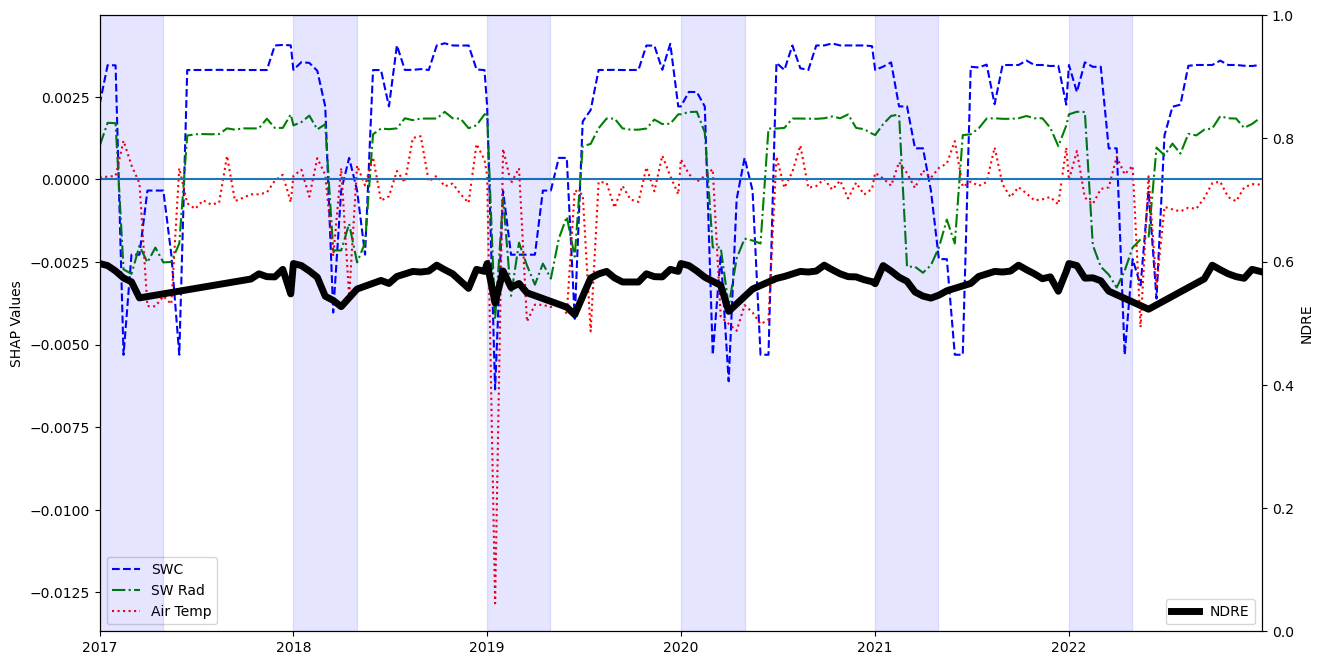

In [39]:
# plot swvl4_3 time series 
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.plot(dates, bci_shap_values[:,26], color='blue', ls='--', label='SWC')
#ax.plot(dates, bci_shap_values[:,32], color='green')
ax.plot(dates, bci_shap_values[:,22], color='green', ls='-.', label='SW Rad')
ax.plot(dates, bci_shap_values[:,5], color='red', ls=':', label='Air Temp')
ax.set_ylabel("SHAP Values")

ax.axhline(y=0.0)
ax2 = ax.twinx() 
#ax2.plot(bci_era5_subset.time, (bci_era5_subset.tp.values), color='blue', ls='--', marker='o')
#ax2.set_ylabel("Total Precipitation [m]")

ax2.plot(dates, bci_ndre.to_numpy()[0], color='black', lw='5', label='NDRE')
ax2.set_ylabel("NDRE")
ax2.set_ylim([0,1])
ax.legend(loc="lower left")
ax2.legend(loc="lower right")

plt.axvspan(datetime.date(2017, 1, 1), datetime.date(2017, 4, 30), alpha=0.10, color='blue')
plt.axvspan(datetime.date(2018, 1, 1), datetime.date(2018, 4, 30), alpha=0.10, color='blue')
plt.axvspan(datetime.date(2019, 1, 1), datetime.date(2019, 4, 30), alpha=0.10, color='blue')
plt.axvspan(datetime.date(2020, 1, 1), datetime.date(2020, 4, 30), alpha=0.10, color='blue')
plt.axvspan(datetime.date(2021, 1, 1), datetime.date(2021, 4, 30), alpha=0.10, color='blue')
plt.axvspan(datetime.date(2022, 1, 1), datetime.date(2022, 4, 30), alpha=0.10, color='blue')

ax.set_xlim([datetime.date(2017, 1, 1), datetime.date(2022, 12, 31)])
plt.savefig('BCI_shap_values.png')

(17167.0, 17531.0)

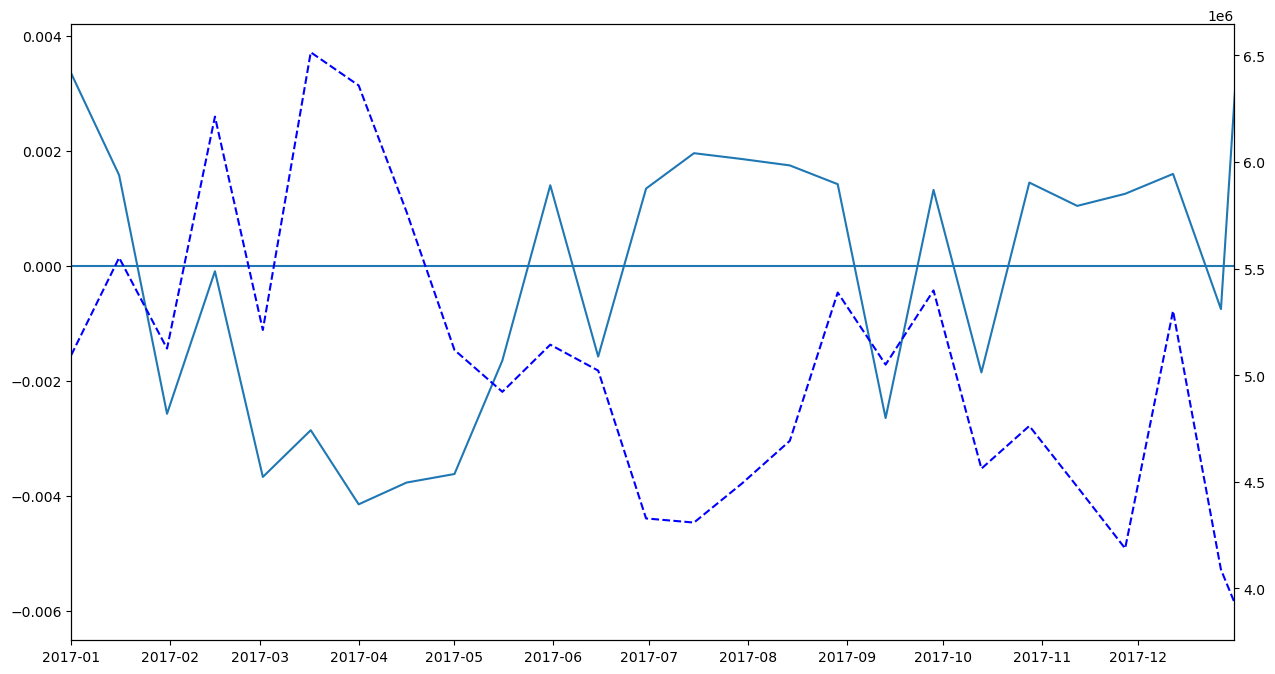

In [26]:
# plot swvl4_3 time series 
fig, ax = plt.subplots(1,1, figsize=(15,8))
#ax.plot(dates, bci_shap_values[:,26]) # swvl4_3
ax.plot(dates, bci_shap_values[:,32]) # ssrd_1

ax.axhline(y=0.0)
ax2 = ax.twinx() 
ax2.plot(bci_era5_subset.time, bci_era5_subset.ssrd, color='blue', ls='--')
ax.set_xlim([datetime.date(2017, 1, 1), datetime.date(2017, 12, 31)])


Text(0, 0.5, 'total precip')

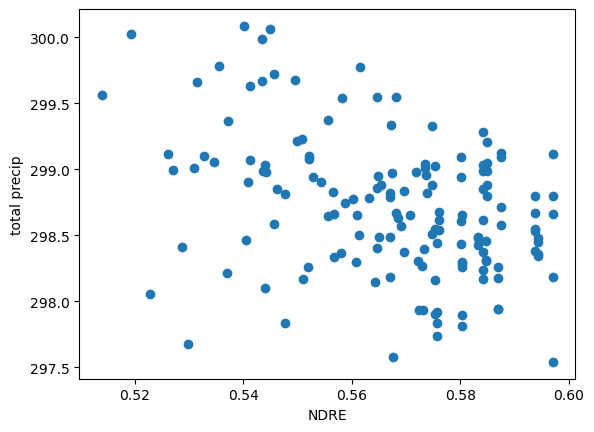

In [27]:
plt.scatter(bci_era5_subset.ndre, bci_era5_subset.t2m)
plt.xlabel('NDRE')
plt.ylabel('total precip')

In [32]:
bci_shap_values.shape
bci_shap_values_simplified.shape
#cats
cats_simplified

['ndre', 't2m', 'tp', 'swvl', 'vpd', 'ssrd']

(17167.0, 17531.0)

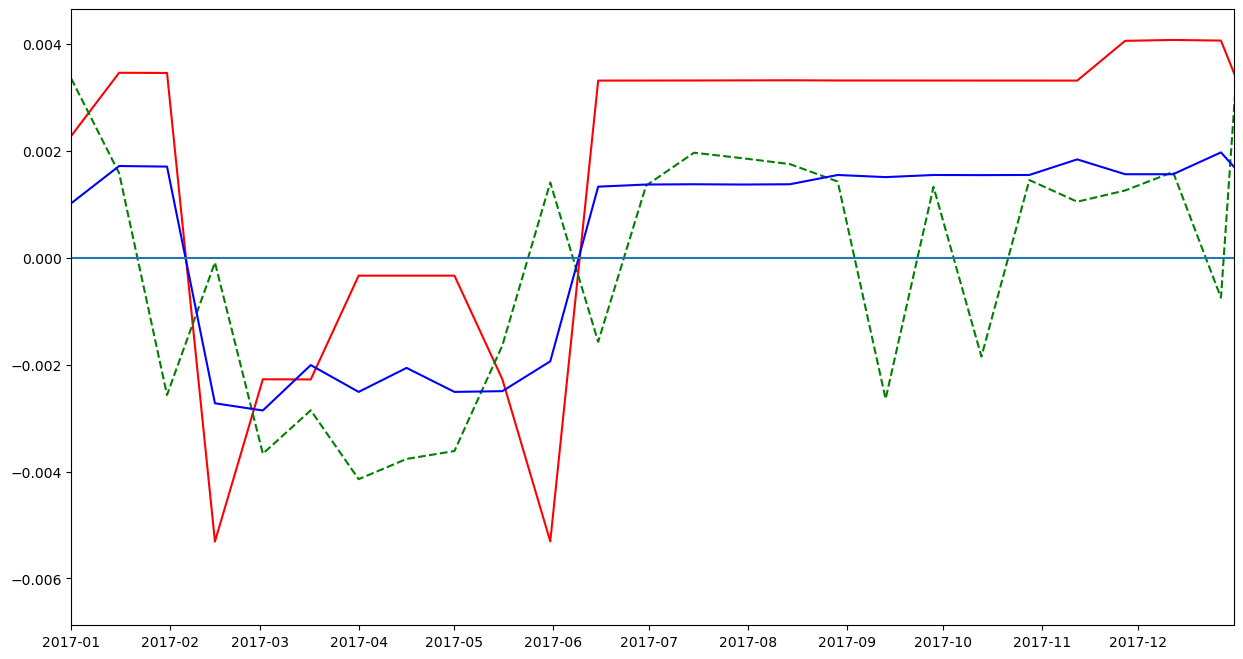

In [161]:
# plot swvl4_3 time series 
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.plot(dates, bci_shap_values[:,26], color='red') # swvl4_3
ax.plot(dates, bci_shap_values[:,32], color='green', ls='--') # ssrd_1
ax.plot(dates, bci_shap_values[:,22], color='blue') # swvl3_3

ax.axhline(y=0.0)
#ax2 = ax.twinx() 
#ax2.plot(bci_era5_subset.time, bci_era5_subset.ssrd, color='blue', ls='--')
ax.set_xlim([datetime.date(2017, 1, 1), datetime.date(2017, 12, 31)])


In [177]:
pd.date_range('2017-01-01', periods=25, freq='15D')

DatetimeIndex(['2017-01-01', '2017-01-16', '2017-01-31', '2017-02-15',
               '2017-03-02', '2017-03-17', '2017-04-01', '2017-04-16',
               '2017-05-01', '2017-05-16', '2017-05-31', '2017-06-15',
               '2017-06-30', '2017-07-15', '2017-07-30', '2017-08-14',
               '2017-08-29', '2017-09-13', '2017-09-28', '2017-10-13',
               '2017-10-28', '2017-11-12', '2017-11-27', '2017-12-12',
               '2017-12-27'],
              dtype='datetime64[ns]', freq='15D')

In [179]:
np.flip(np.absolute(bci_shap_values).mean(axis=1).argsort())

array([ 61,  62,  81,   0, 136, 134, 137,  51,  82,  63,  58,  30,  25,
       138, 139,  32,  60,  59, 135,  57,  52, 133, 107,  31,  33,  83,
        56,   6, 106, 108, 132,  55, 131,  28,   7,  84,   8,  53,  80,
       125,  43, 130,  54,  50, 102, 140,   3,  93,  75,  99,  11, 123,
         4, 118,  24,   9,   5, 110, 105,  12,  47, 109, 149,   1,  79,
        76,  10,  26,  48,  44,  94, 141, 124, 126,  42,  27,  92,  96,
         2,  85,  78,  14, 117, 101,  41, 100, 119,  13,  15, 127, 129,
        49,  23,  91,  86, 111,  45,  34, 104,  35,  73,  40, 128, 144,
       120,  46, 116,  95,  90,  39,  66,  29, 121, 103,  71, 147, 148,
       112, 145,  65,  74,  77, 146,  89, 115,  64,  36,  21,  70,  98,
        38,  97,  88,  67, 114,  72,  20,  18, 142,  68,  87,  17,  22,
       122,  37,  69,  16, 113,  19, 143])

In [271]:
#for t in range(0,150):
ts_order = np.flip(np.absolute(bci_shap_values).argsort())
ts_order
dom_ts = np.zeros((150,32), dtype=np.int64)
#dom_ts = pd.Dcats[3:]
for t in range(0,150):
    #print(dates[t])
    dom = nondre_dominant(pd.DataFrame(ts_order[t,:]).T)
    dom_ts[t,:] = np.array(dom, dtype=np.int64)
    #dom_ts = np.append(dom_ts, dom, axis=1)
    #print(dom)

In [272]:
len(dom_ts)#[3:]
len(dom)
dom_ts[:,0]
np.array(dom, dtype=np.int64)

array([32, 26, 27,  4, 34, 12, 22,  8, 10, 16, 11, 29,  3, 33, 24,  7, 14,
       28,  5, 21, 19, 20,  9,  6, 31, 17, 13, 18, 30, 23, 15, 25])

In [277]:
unique, frequency = np.unique(dom_ts[:,2], 
                              return_counts = True)
print(unique)
print(frequency)

[ 3  4  5  6  8 10 11 12 13 14 22 26 27 30 32 33]
[ 1  1  1  2  2  9  1 27  1  7 36  9  6  4 33 10]


In [284]:
bci_shap_values.shape
print(bci_shap_values.mean(axis=0)[[26,32,22]])
print(bci_shap_values.min(axis=0)[[26,32,22]])
print(bci_shap_values.max(axis=0)[[26,32,22]])

[ 0.0016598  -0.00022759  0.00042459]
[-0.00635209 -0.00602054 -0.00422846]
[0.00412181 0.00371748 0.00204881]


In [301]:
np.absolute(bci_shap_values[0,:]).sum()

0.04847211211654114

In [313]:
data = np.absolute(bci_shap_values[0,:])*100/np.absolute(bci_shap_values[0,:]).sum()
data.argsort()
#np.flip(data)#.argsort()

array([25, 15, 23, 30, 18, 13, 17, 31,  6,  9, 20, 19, 21,  5, 28, 14,  7,
       24, 33,  3,  2, 29, 11, 16, 10,  8, 22, 12, 34,  4, 27, 26, 32,  1,
        0])

In [314]:
np.flip(data).argsort()

array([ 9, 19, 11,  4, 16, 21, 17,  3, 28, 25, 14, 15, 13, 29,  6, 20, 27,
       10,  1, 31, 32,  5, 23, 18, 24, 26, 12, 22,  0, 30,  7,  8,  2, 33,
       34])

In [328]:
print(data)

[5.18466493e+01 1.06710814e+01 1.23915144e+00 1.06766031e+00
 3.50160733e+00 1.33139014e-01 4.31298007e-02 2.78785525e-01
 1.57384207e+00 4.92691684e-02 1.42682075e+00 1.32870291e+00
 2.36689512e+00 2.43874909e-02 2.70368448e-01 5.08309206e-03
 1.34106084e+00 3.55744975e-02 1.89534865e-02 1.17810559e-01
 9.38346960e-02 1.18711915e-01 2.09813539e+00 8.05560290e-03
 3.03104597e-01 0.00000000e+00 4.69776238e+00 3.59600506e+00
 1.91649214e-01 1.30283015e+00 1.41558493e-02 3.66630629e-02
 6.90980545e+00 3.07289884e-01 2.98202422e+00]


In [317]:
data.argsort()

array([25, 15, 23, 30, 18, 13, 17, 31,  6,  9, 20, 19, 21,  5, 28, 14,  7,
       24, 33,  3,  2, 29, 11, 16, 10,  8, 22, 12, 34,  4, 27, 26, 32,  1,
        0])

In [327]:
data[25]

0.0

In [316]:
np.flip(data)

array([2.98202422e+00, 3.07289884e-01, 6.90980545e+00, 3.66630629e-02,
       1.41558493e-02, 1.30283015e+00, 1.91649214e-01, 3.59600506e+00,
       4.69776238e+00, 0.00000000e+00, 3.03104597e-01, 8.05560290e-03,
       2.09813539e+00, 1.18711915e-01, 9.38346960e-02, 1.17810559e-01,
       1.89534865e-02, 3.55744975e-02, 1.34106084e+00, 5.08309206e-03,
       2.70368448e-01, 2.43874909e-02, 2.36689512e+00, 1.32870291e+00,
       1.42682075e+00, 4.92691684e-02, 1.57384207e+00, 2.78785525e-01,
       4.31298007e-02, 1.33139014e-01, 3.50160733e+00, 1.06766031e+00,
       1.23915144e+00, 1.06710814e+01, 5.18466493e+01])

In [319]:
np.flip(data).argsort()

array([ 9, 19, 11,  4, 16, 21, 17,  3, 28, 25, 14, 15, 13, 29,  6, 20, 27,
       10,  1, 31, 32,  5, 23, 18, 24, 26, 12, 22,  0, 30,  7,  8,  2, 33,
       34])

In [324]:
np.flip(data)[9]

0.0

In [329]:
dominant = np.flip(np.absolute(bci_shap_values).mean(axis=0).argsort())
dominant

array([ 0, 26, 32, 22,  1, 12,  5, 33, 14, 27, 10,  6,  2, 29, 30,  4, 16,
        3, 34, 13,  8, 28, 11,  7, 31, 21, 24,  9, 17, 20, 15, 23, 19, 18,
       25])

In [330]:
np.absolute(bci_shap_values).mean(axis=0)

array([6.73892358e-03, 1.62889396e-03, 5.60344429e-04, 4.37769484e-04,
       4.72070341e-04, 1.02280657e-03, 5.67099710e-04, 1.35658419e-04,
       2.12813336e-04, 4.87631058e-05, 6.37933124e-04, 2.09321177e-04,
       1.31307523e-03, 3.78622366e-04, 8.06722843e-04, 2.17415067e-05,
       4.46195469e-04, 3.97741358e-05, 8.87166634e-06, 1.14430148e-05,
       2.88177713e-05, 7.86431928e-05, 1.85210549e-03, 1.38479144e-05,
       5.43670958e-05, 0.00000000e+00, 3.02019698e-03, 7.46642587e-04,
       2.12794932e-04, 5.35322271e-04, 5.30187487e-04, 1.04701034e-04,
       2.07867222e-03, 9.49620776e-04, 4.30724963e-04])

In [355]:
data = np.absolute(bci_shap_values).mean(axis=0)*100/np.absolute(bci_shap_values).mean(axis=0).sum()
np.flip(data.argsort())

array([ 0, 26, 32, 22,  1, 12,  5, 33, 14, 27, 10,  6,  2, 29, 30,  4, 16,
        3, 34, 13,  8, 28, 11,  7, 31, 21, 24,  9, 17, 20, 15, 23, 19, 18,
       25])

array([ 9, 16, 15, 11, 19, 14, 17, 25, 10, 13,  3, 27, 23,  6, 26, 21,  0,
       31, 18, 30,  4,  5, 32, 28, 24,  7, 20,  1, 29, 22, 33, 12,  2,  8,
       34])

array([25.58875512,  6.18516715,  2.12771612,  1.66227974,  1.7925255 ,
        3.88375777,  2.15336699,  0.5151164 ,  0.80808578,  0.1851612 ,
        2.42233263,  0.79482551,  4.98595363,  1.43768881,  3.0632538 ,
        0.08255593,  1.69427453,  0.15102866,  0.03368712,  0.04345093,
        0.10942562,  0.2986206 ,  7.03273649,  0.05258271,  0.20644043,
        0.        , 11.46816401,  2.8351196 ,  0.8080159 ,  2.03270305,
        2.01320546,  0.39756633,  7.8930461 ,  3.60585978,  1.63553058])

0.02633548817968747